In [1]:
import decimal
from collections import defaultdict
import matplotlib
import numpy as np
import itertools
import os
import pandas as pd
import datetime
from joblib import dump
import json
from matplotlib import pyplot as plt
from tqdm import tqdm
import glob
import pdb
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import fbeta_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import roc_curve, auc
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.insert(0, '../../scripts/modeling_toolbox/')
sys.path.insert(0, '../../')
import utils
from scripts.asset_processor import VideoAssetProcessor

%matplotlib notebook
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize']=[10,6]
pd.options.display.width = 0
pd.set_option('display.max_columns', None)

In [2]:
%matplotlib notebook

In [3]:
FEATURES_UL = ['size_dimension_ratio',
               'temporal_dct-mean',
               'temporal_gaussian_mse-mean',
               'temporal_gaussian_difference-mean',
               'temporal_threshold_gaussian_difference-mean',
               'temporal_histogram_distance-mean'
               ]

FEATURES_SL = ['size_dimension_ratio',
               'temporal_dct-mean',
               'temporal_gaussian_mse-mean',
               'temporal_gaussian_difference-mean',
               'temporal_threshold_gaussian_difference-mean',
               'temporal_histogram_distance-mean'
               ]
FEATURES_META = ['cat_cl_pred','ocsvm_pred']
# Target variable, 1 represents Tamper, 0 is correct rendition
TARGET = ['target']

train_fraction = 0.85

In [57]:
# read data
data = utils.load_data('../../../data/data-new-metrics.csv')
# remove low bitrate renditions
data = data[~data.rendition.str.contains('bitrate')]
data = data[~data.rendition.str.contains('chroma')]
data
data = VideoAssetProcessor.rescale_to_resolution(data, FULL_FEATURES)
len_before = len(data)

Upscaling temporal_dct temporal_dct-mean
Upscaling temporal_gaussian_mse temporal_gaussian_mse-mean
Upscaling temporal_gaussian_difference temporal_gaussian_difference-mean
Upscaling temporal_histogram_distance temporal_histogram_distance-mean


In [58]:
# drop all columns without some of the features
data.dropna(axis=0, subset=FEATURES_SL+FEATURES_UL, inplace=True)
print(f'Removed {len_before - len(data)} NA rows')

Removed 0 NA rows


In [59]:
# split test and train making sure source and its renditions are not split
np.random.seed(1337)
master_ids = data.master_id.unique()
train_master_ids = np.random.choice(master_ids, int(train_fraction*master_ids.shape[0]), replace=False)
train_idx = np.isin(data.master_id, train_master_ids)
train_data = data[train_idx]
test_idx = ~data.index.isin(train_data.index)
test_data = data[test_idx]
y_test = test_data['target']
y_train = train_data['target']
# save split
train_data.to_csv('train_data.csv')
test_data.to_csv('test_data.csv')

In [60]:
# renditions by type
print('Test data top rendition types:')
test_data.groupby('rendition').rendition.count().sort_values().tail(15)

Test data top rendition types:


rendition
240p_watermark               340
480p_black_and_white         341
480p_rotate_90_clockwise     341
1080p_black_and_white        343
240p                         344
720p_rotate_90_clockwise     345
360p_watermark-856x856       346
240p_vignette                346
480p_flip_horizontal         347
360p_flip_horizontal         347
144p_rotate_90_clockwise     349
720p_black_and_white         350
1080p_rotate_90_clockwise    358
144p_watermark               360
1080p_vignette               361
Name: rendition, dtype: int64

In [61]:
train_data[FULL_FEATURES].describe()

,size_dimension_ratio,temporal_dct-mean,temporal_gaussian_difference-mean,temporal_gaussian_mse-mean,temporal_histogram_distance-mean,temporal_threshold_gaussian_difference-mean
count,89732.000000,8.973200e+04,8.973200e+04,89732.000000,8.973200e+04,89732.000000
mean,2.956195,1.181635e+07,6.223572e+09,16378.349428,1.584695e+05,22044.666186
std,1.375813,2.522483e+07,1.351779e+10,46387.851394,5.422460e+05,25646.720440
min,0.016935,2.671321e+02,4.398244e+04,0.000220,0.000000e+00,0.000000
25%,2.128101,2.578504e+05,1.609556e+08,73.670767,2.371420e+03,1008.444444
50%,2.962325,1.770533e+06,8.082302e+08,928.940517,6.363462e+03,4724.000000
75%,3.567212,9.789811e+06,4.897870e+09,8887.653098,3.256361e+04,44070.611111
max,19.957878,4.743106e+08,1.707865e+11,896108.825231,8.507153e+06,129600.000000


In [62]:
(train_data['size']/(train_data['dimension_x']*train_data['dimension_y'])).describe()

count    89732.000000
mean         2.956195
std          1.375813
min          0.016935
25%          2.128101
50%          2.962325
75%          3.567212
max         19.957878
dtype: float64

In [63]:
# class balance, 1 is tampered rendition, 0 is accurate rendition
print('Test data class balance:')
test_data.groupby('target').target.count()

Test data class balance:


target
0     1648
1    14152
Name: target, dtype: int64

In [64]:
# test renditions by type
print('Test data FPS renditions count:')
test_data[test_data.rendition.str.contains('fps')]['target']

Test data FPS renditions count:


id
1080p_watermark-856x856_24-30fps_gpu/-apHZNnZSL4.mp4            1
1080p_rotate_90_clockwise_24-60fps/-ewkJboodaE.mp4              1
1080p_vignette_25-30fps/4PpxM7P2M1c.mp4                         1
144p_24-60fps/4f49m5mZE3M.mp4                                   0
1080p_flip_horizontal_30-24fps_gpu/3fSUvsWTqpA.mp4              1
1080p_25-30fps_gpu/DjL38nRWbkE.mp4                              0
1080p_flip_vertical_24-60fps_gpu/nmI2HLSirHY.mp4                1
144p_24-30fps/0b9uySaNopg.mp4                                   0
144p_vignette_30-24fps_gpu/GOh-RhD_p2Y.mp4                      1
144p_25-30fps_gpu/2X-b-7gWMQI.mp4                               0
144p_rotate_90_counterclockwise_30-24fps_gpu/VUtmahnh1nM.mp4    1
1080p_vignette_24-60fps_gpu/-QmLoLkURHw.mp4                     1
1080p_rotate_90_clockwise_24-30fps/-QmLoLkURHw.mp4              1
1080p_watermark-856x856_24-30fps/1jKx0x-ymYM.mp4                1
144p_flip_horizontal_24-60fps/iSleTtlfTCw.mp4                   1
144p_vi

In [65]:
### OCSVM MODEL
# fit outlier detector to tampered videos as a bigger class
x_train_ul = np.asarray(train_data[FEATURES_UL][train_data.target==0])
x_test_ul = np.asarray(test_data[FEATURES_UL])
# scale the data
scaler = StandardScaler()
x_train_ul = scaler.fit_transform(x_train_ul)
x_test_ul = scaler.transform(x_test_ul)
# fit the model
oc_svm = svm.OneClassSVM(kernel='rbf', gamma=0.3, nu=0.001, cache_size=5000)
oc_svm.fit(x_train_ul)
def ocsvm_score_converter(score):
    return 1-1/(1+np.exp(-score))
# get predictions on test and convert them with sigmoid function to (0,1) interval
test_data['ocsvm_pred'] = ocsvm_score_converter(oc_svm.decision_function(x_test_ul))
# add predictions to train data
train_data['ocsvm_pred'] = ocsvm_score_converter(oc_svm.decision_function(np.asarray(train_data[FEATURES_UL])))
test_data['ocsvm_pred_label'] = (-oc_svm.predict(x_test_ul)+1)/2
# dump scaler and model
dump(scaler, '../output/models/OCSVM_StandardScaler_v2.joblib')
dump(oc_svm, '../output/models/OCSVM_v2.joblib')

['../output/models/OCSVM_v2.joblib']

In [66]:
### CATBOOST MODEL
cat_features = []
# Initialize CatBoostClassifier
cb_params = dict(iterations=500,
                 learning_rate=0.05,
                 depth=6)
catboost_binary = CatBoostClassifier(**cb_params)
# Fit model
cat_x_train = np.asarray(train_data[FEATURES_SL])
catboost_binary.fit(cat_x_train, train_data['target'], cat_features)
cat_x_test = np.asarray(test_data[FEATURES_SL])
test_data['cat_cl_pred'] = catboost_binary.predict_proba(cat_x_test)[:,1]
test_data['cat_cl_y_pred_label'] = catboost_binary.predict(cat_x_test)
# add predictions to train data
train_data['cat_cl_pred'] = catboost_binary.predict_proba(cat_x_train)[:,1]
catboost_binary.save_model('../output/models/CB_Binary_v2.cbm',
                           format="cbm",
                           export_parameters=None,
                           pool=None)


0:	learn: 0.5365482	total: 9.6ms	remaining: 4.79s
1:	learn: 0.4285625	total: 17.1ms	remaining: 4.25s
2:	learn: 0.3343304	total: 25.1ms	remaining: 4.16s
3:	learn: 0.2683863	total: 32ms	remaining: 3.97s
4:	learn: 0.2203283	total: 39.1ms	remaining: 3.87s
5:	learn: 0.1855775	total: 46.8ms	remaining: 3.85s
6:	learn: 0.1611551	total: 54ms	remaining: 3.8s
7:	learn: 0.1430959	total: 61.4ms	remaining: 3.78s
8:	learn: 0.1287467	total: 68.5ms	remaining: 3.73s
9:	learn: 0.1173274	total: 75.5ms	remaining: 3.7s
10:	learn: 0.1081188	total: 82.4ms	remaining: 3.66s
11:	learn: 0.1009360	total: 89.5ms	remaining: 3.64s
12:	learn: 0.0950090	total: 96.5ms	remaining: 3.62s
13:	learn: 0.0896229	total: 104ms	remaining: 3.6s
14:	learn: 0.0851802	total: 111ms	remaining: 3.58s
15:	learn: 0.0819729	total: 118ms	remaining: 3.58s
16:	learn: 0.0791531	total: 126ms	remaining: 3.58s
17:	learn: 0.0761045	total: 133ms	remaining: 3.57s
18:	learn: 0.0739566	total: 140ms	remaining: 3.55s
19:	learn: 0.0719644	total: 148ms	re

174:	learn: 0.0440632	total: 1.62s	remaining: 3.01s
175:	learn: 0.0440344	total: 1.63s	remaining: 3s
176:	learn: 0.0440074	total: 1.64s	remaining: 2.99s
177:	learn: 0.0439755	total: 1.65s	remaining: 2.98s
178:	learn: 0.0439265	total: 1.66s	remaining: 2.97s
179:	learn: 0.0439041	total: 1.66s	remaining: 2.96s
180:	learn: 0.0438466	total: 1.67s	remaining: 2.94s
181:	learn: 0.0438013	total: 1.68s	remaining: 2.94s
182:	learn: 0.0437660	total: 1.69s	remaining: 2.93s
183:	learn: 0.0437192	total: 1.7s	remaining: 2.92s
184:	learn: 0.0436773	total: 1.71s	remaining: 2.92s
185:	learn: 0.0436378	total: 1.73s	remaining: 2.91s
186:	learn: 0.0436015	total: 1.73s	remaining: 2.9s
187:	learn: 0.0435596	total: 1.75s	remaining: 2.9s
188:	learn: 0.0435405	total: 1.75s	remaining: 2.89s
189:	learn: 0.0435047	total: 1.77s	remaining: 2.88s
190:	learn: 0.0434660	total: 1.78s	remaining: 2.88s
191:	learn: 0.0434283	total: 1.79s	remaining: 2.87s
192:	learn: 0.0433675	total: 1.8s	remaining: 2.87s
193:	learn: 0.04334

334:	learn: 0.0398325	total: 3.04s	remaining: 1.5s
335:	learn: 0.0398275	total: 3.04s	remaining: 1.49s
336:	learn: 0.0398006	total: 3.05s	remaining: 1.48s
337:	learn: 0.0397783	total: 3.06s	remaining: 1.47s
338:	learn: 0.0397447	total: 3.07s	remaining: 1.46s
339:	learn: 0.0397402	total: 3.08s	remaining: 1.45s
340:	learn: 0.0397361	total: 3.08s	remaining: 1.44s
341:	learn: 0.0397324	total: 3.09s	remaining: 1.43s
342:	learn: 0.0397289	total: 3.1s	remaining: 1.42s
343:	learn: 0.0397258	total: 3.1s	remaining: 1.41s
344:	learn: 0.0397121	total: 3.11s	remaining: 1.4s
345:	learn: 0.0396931	total: 3.12s	remaining: 1.39s
346:	learn: 0.0396721	total: 3.13s	remaining: 1.38s
347:	learn: 0.0396605	total: 3.14s	remaining: 1.37s
348:	learn: 0.0396512	total: 3.15s	remaining: 1.36s
349:	learn: 0.0396271	total: 3.15s	remaining: 1.35s
350:	learn: 0.0396006	total: 3.16s	remaining: 1.34s
351:	learn: 0.0395773	total: 3.17s	remaining: 1.33s
352:	learn: 0.0395668	total: 3.18s	remaining: 1.32s
353:	learn: 0.03

498:	learn: 0.0393588	total: 4.65s	remaining: 9.32ms
499:	learn: 0.0393588	total: 4.66s	remaining: 0us


In [67]:
# voting model
test_data['meta_voting_pred_label'] = np.where(test_data['ocsvm_pred_label']==0, 0, test_data['cat_cl_y_pred_label'])
test_data[['meta_voting_pred_label','cat_cl_y_pred_label','ocsvm_pred_label']]
#test_data['meta_voting_pred'] = (test_data['cat_cl_pred']*2 + test_data['ocsvm_pred'])/2

,meta_voting_pred_label,cat_cl_y_pred_label,ocsvm_pred_label
id,,,
720p_black_and_white/ALTlJUod2jU.mp4,1,1,1.0
144p_rotate_90_clockwise/g0HJWlDb-ao.mp4,1,1,1.0
720p_rotate_90_clockwise/E1Q-z2emjWQ.mp4,1,1,1.0
720p_flip_horizontal/rgchsYcBVWI.mp4,1,1,1.0
1080p_vignette/ikq4BH64p_I.mp4,1,1,1.0
720p_rotate_90_clockwise/9jmHc2dMA7o.mp4,1,1,1.0
1080p_black_and_white/WzWJpCfhhgU.mp4,1,1,1.0
720p/d0lOMYVQsPs.mp4,0,0,0.0
144p_black_and_white/beVH1-KiSbM.mp4,1,1,1.0


In [68]:
def multi_model_perf(y, y_preds, labs, cols=['green', 'orange', 'red', 'black', 'blue', 'yellow', 'magenta'], report_threshold=[0.5]):
    plt.figure()
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Model ROC comparison')
    for y_pred, lab, col, preset_t in zip(y_preds, labs, cols, report_threshold):
        fpr, tpr, thresh = roc_curve(y, y_pred, pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=col,
                 lw=2, label=lab+' AUC=%0.2f' % roc_auc)
        print('##################')
        print(f'{lab} ROC threshold: {preset_t}')
        print(f'{lab} classification report:')
        print(classification_report(y, y_pred>preset_t))
        print(f'{lab} confusion matrix:')
        print(confusion_matrix(y, y_pred>preset_t))
    plt.legend(loc="lower right")
    plt.show()

<IPython.core.display.Javascript object>


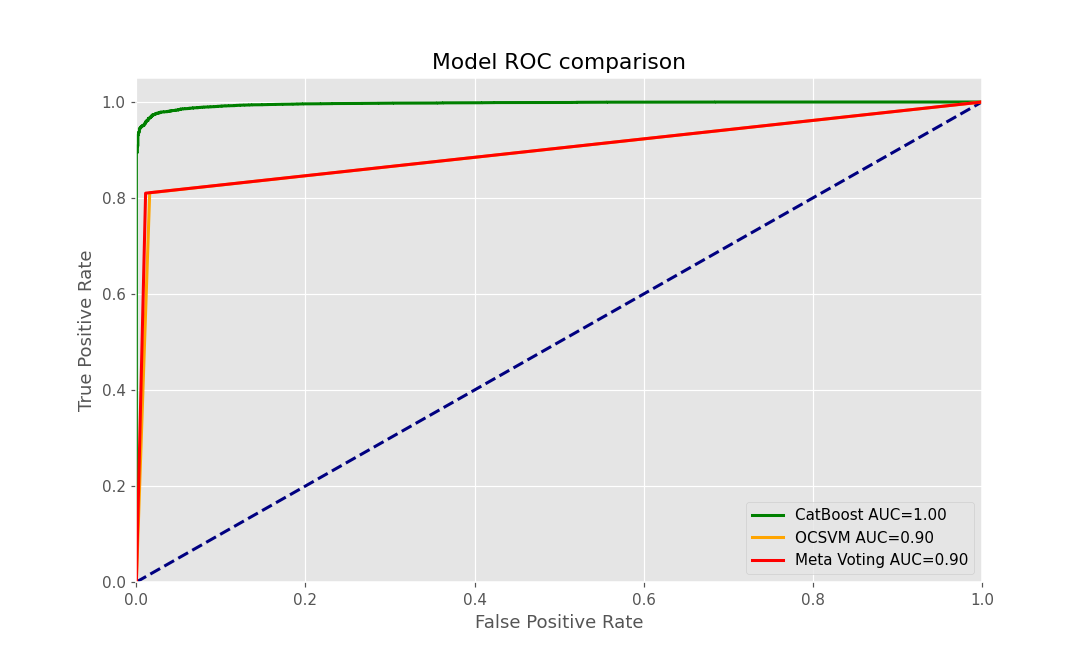

##################
CatBoost ROC threshold: 0.5
CatBoost classification report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1648
           1       0.99      0.99      0.99     14152

    accuracy                           0.98     15800
   macro avg       0.94      0.96      0.95     15800
weighted avg       0.98      0.98      0.98     15800

CatBoost confusion matrix:
[[ 1539   109]
 [  180 13972]]
##################
OCSVM ROC threshold: 0.5
OCSVM classification report:
              precision    recall  f1-score   support

           0       0.38      0.98      0.55      1648
           1       1.00      0.81      0.89     14152

    accuracy                           0.83     15800
   macro avg       0.69      0.90      0.72     15800
weighted avg       0.93      0.83      0.86     15800

OCSVM confusion matrix:
[[ 1622    26]
 [ 2677 11475]]
##################
Meta Voting ROC threshold: 0.5
Meta Voting classification repo

In [69]:
multi_model_perf(y_test, [test_data['cat_cl_pred'], test_data['ocsvm_pred_label'], test_data['meta_voting_pred_label']], 
              ['CatBoost', 'OCSVM','Meta Voting'], report_threshold=[0.5,0.5,0.5])

In [75]:
print('Hardest rendition types:')
test_data[test_data.cat_cl_y_pred_label!=test_data.target].groupby('rendition').rendition.count().sort_values().tail(15)

Hardest rendition types:


rendition
1080p_watermark-345x114     4
144p_watermark              4
240p_black_and_white        6
720p                        6
720p_watermark-856x856      7
480p                        9
144p_black_and_white       10
720p_watermark-345x114     13
480p_watermark-345x114     17
360p                       21
240p                       25
240p_watermark-345x114     28
360p_watermark-345x114     31
144p_watermark-345x114     31
144p                       46
Name: rendition, dtype: int64

In [25]:
print('Feature importance:')
importance = catboost_full.get_feature_importance(prettified=True)
importance['Feature Name']=np.array(FULL_FEATURES)[importance['Feature Id'].values.astype(np.int32)]
importance

Feature importance:


,Feature Id,Importances,Feature Name
0,4,27.289888,temporal_threshold_gaussian_difference-mean
1,0,21.323844,size_dimension_ratio
2,1,20.522501,temporal_dct-mean
3,3,18.282202,temporal_gaussian_mse-mean
4,2,12.581565,temporal_gaussian_difference-mean


FPS Renditions


<IPython.core.display.Javascript object>


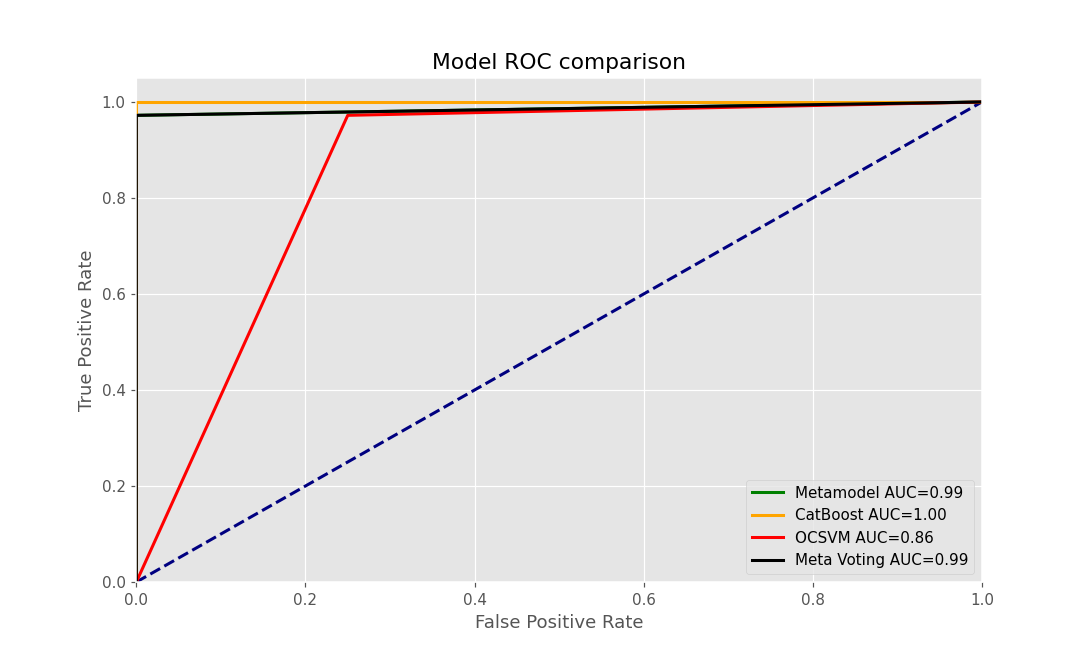

##################
Metamodel ROC threshold: 0.5
Metamodel classification report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.97      0.99        36

    accuracy                           0.98        44
   macro avg       0.94      0.99      0.96        44
weighted avg       0.98      0.98      0.98        44

Metamodel confusion matrix:
[[ 8  0]
 [ 1 35]]
##################
CatBoost ROC threshold: 0.5
CatBoost classification report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.95      1.00      0.97        36

    accuracy                           0.95        44
   macro avg       0.97      0.88      0.92        44
weighted avg       0.96      0.95      0.95        44

CatBoost confusion matrix:
[[ 6  2]
 [ 0 36]]
##################
OCSVM ROC threshold: 0.5
OCSVM classification report:
              precis

In [79]:
print('FPS Renditions')
fps_test_idx = test_data.id.str.contains('fps')
y_test_fps = test_data[fps_test_idx]['target']
multi_model_perf(y_test_fps, [test_data[fps_test_idx]['meta_voting_pred_label'], test_data[fps_test_idx]['cat_cl_pred'], test_data[fps_test_idx]['ocsvm_pred_label'],
                      test_data[fps_test_idx]['meta_voting_pred_label']], 
              ['Metamodel','CatBoost', 'OCSVM',
               'Meta Voting'], report_threshold=[0.5,0.5,0.5,0.5])